# Lab course: Computational statistical mechanics

# Machine learning of the simple Ising model in 2D

## 1. Code for a MC Ising simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd

### *1.1 Initialization and calculation of the Energy difference*

In [2]:
@njit
def init(n=10, random=False):
    grid = np.zeros(shape=(n,n), dtype = np.int64)
    if random:
        grid = np.random.randint(0,2,size = (n,n))
    grid = np.where(grid==0,-1,grid)
    return grid

In [3]:
@njit
def calculate_energy_diff(x,grid,J=1,B=0):
    H = np.zeros(2)
    y = np.where(x==grid.shape[0]-1,-1,x)
    j = 1
    for i in range(2):
        S = 0
        S+= grid[x[0],x[1]]*grid[x[0]-1,x[1]]*j
        S+= grid[x[0],x[1]]*grid[y[0]+1,x[1]]*j
        S+= grid[x[0],x[1]]*grid[x[0],x[1]-1]*j
        S+= grid[x[0],x[1]]*grid[x[0],y[1]+1]*j
        H[i] = S
        j = -1
    H_diff = -J*(H[1] - H[0])+ B*2*grid[x[0],x[1]]
    return H_diff

### *1.2 Monte Carlo simulation* 

In [4]:
@njit
def spin_flip(grid, T, J ,B):
    M_diff = 0
    x = np.random.randint(0,grid.shape[0],size=2)
    H_diff = calculate_energy_diff(x,grid, J, B)
    if T == 0:
        if H_diff <= 0:
            grid[x[0],x[1]] = grid[x[0],x[1]]*-1
            M_diff = grid[x[0],x[1]]*-2
          
    else:
        r = np.random.random()
        if r < np.exp(-H_diff/T):
            grid[x[0],x[1]] = grid[x[0],x[1]]*-1
            M_diff = grid[x[0],x[1]]*-2

    return M_diff

### *1.3 Functions to calculate the data for the plots*

In [5]:
@njit
def m_of_t(steps, T, N, random, J, B, val = 1):
    n_acc = 0
    M = np.zeros(steps)
    grid = init(N, random)
    grid = grid * val
    M[0] = np.sum(grid)/N**2
    for j in range(1,steps):
        M_diff = spin_flip(grid,T, J, B)
        M[j] = M[j-1] - M_diff/N**2
    return M, grid

In [6]:
@njit
def m_of_Temp(T, N, steps, equi, J, B, random = True):
    M_of_T = np.zeros(T.size)
    for i in range(T.size):
        M = np.abs(m_of_t(steps, T[i], N, random, J, B)[0])
        M_of_T[i] = np.mean(M[equi:])
    return M_of_T

In [7]:
@njit
def m_of_B(T, N, steps, equi, J, B, both = True, random = True):
    M_of_B = np.zeros((2,B.size))
    for i in range(B.size):
        M = m_of_t(steps, T, N, random, J, B[i])[0]
        M_of_B[0,i] = np.mean(M[equi:])
    if both:
        for i,j in enumerate(B,0):
            M = m_of_t(steps, T, N, random, J, j, val = -1)[0]
            M_of_B[1,i] = np.mean(M[equi:])
    return M_of_B

In [8]:
@njit
def susceptibility(N,T,steps, equi, B=0, J=1,random = True):
    susc = np.zeros(T.size)
    for i in range(T.size):
        M = m_of_t(steps, T[i], N, random, J, B)[0]
        susc[i] = 1/T[i]*(np.mean(M[equi:]**2)-np.mean(M[:equi])**2)
    return susc

In [9]:
@njit
def create_set(n : int, T : np.array, N : int, steps, J = 1):
    label = np.zeros((n*T.shape[0],3))
    grid = np.zeros((1,N**2), dtype = np.int64)
    for i in range(T.shape[0]*n):
        m = m_of_t(steps, T[int(i/n),0], N, True, J, 0, val = 1)[1].flatten()
        m = np.expand_dims(m,0)
        grid = np.vstack((grid,m))
        label[i] = T[int(i/n)]
    return grid,label

In [10]:
def plot_m(steps, T, N, random, J, B):
    """
    Plots M as a function of the timesteps t.
    """
    M, grid  = m_of_t(steps, T, N, random, J, B)
    steps = M.size
    fig, ax = plt.subplots()
    ax.plot(np.arange(0,steps,1), M,'-.')
    ax.set_xlabel('Steps t')
    ax.set_ylabel('Magnetization M')
    ax.set_title(f'Magnetization M(t)')
    plt.show()
    return grid, M

## Magnetization of timesteps

In [17]:
# System parameters:
N = 40
random_config = True
n_systems = 6
B = 0
J = 1
kT = 4
steps = 5000000

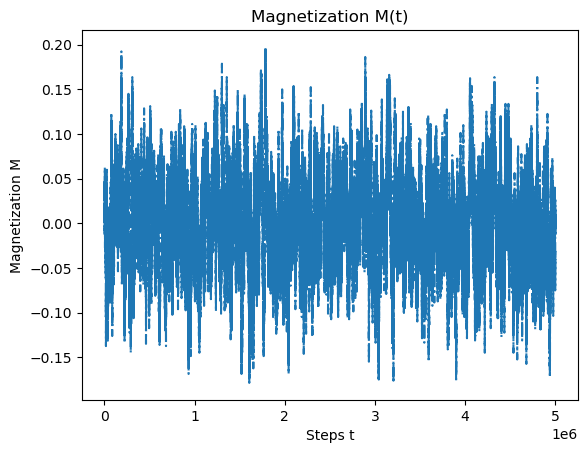

In [18]:
m3 = plot_m(steps, kT, N, random_config, J, B)[1]

In [17]:
np.savetxt("M2.txt",M)

In [11]:
m1 = np.loadtxt("M0.txt")
m2 = np.loadtxt("M1.txt")
m3 = np.loadtxt("M2.txt")

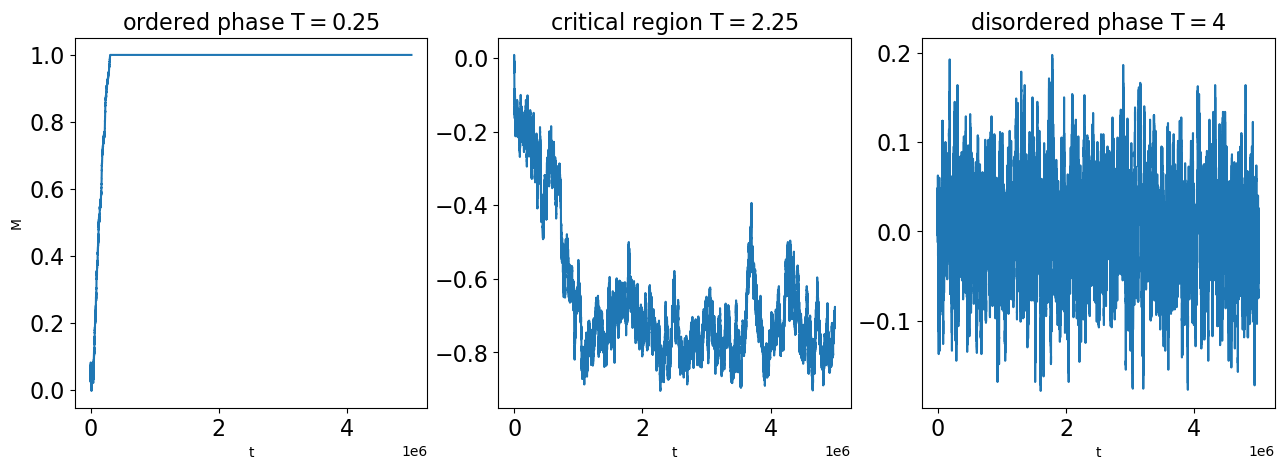

In [24]:
##### plot a few Ising states
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set colourbar map
cmap_args=dict(cmap='tab20')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

#axarr[0].imshow(ordered_X[500].reshape(N,N),**cmap_args)
axarr[0].plot(np.arange(steps),m1)
#axarr[0].hlines(np.mean(m1[2000000:]),2000000,5000000, color = 'red', label = 'mean value')
axarr[0].set_title('$\\mathrm{ordered\\ phase\\ T = 0.25}$',fontsize=16)
axarr[0].tick_params(labelsize=16)
axarr[0].set_ylabel("M")
axarr[0].set_xlabel("t")
#axarr[0].legend()
#axarr[0].set_ylim([0,1])

#axarr[1].imshow(critical_X[400].reshape(N,N),**cmap_args)
axarr[1].plot(np.arange(steps),m2)
#axarr[1].hlines(np.mean(m2[2000000:]),2000000,5000000,color = 'red', label = 'mean value')
axarr[1].set_title('$\\mathrm{critical\\ region\\ T = 2.25}$',fontsize=16)
axarr[1].tick_params(labelsize=16)
axarr[1].set_xlabel("t")
#axarr[1].legend()
#axarr[1].set_ylim([0,1])

#im=axarr[2].imshow(disordered_X[1000].reshape(N,N),**cmap_args)
axarr[2].plot(np.arange(steps),m3)
#axarr[2].hlines(np.mean(m3[2000000:]),2000000,5000000, color = 'red', label = 'mean value')
axarr[2].set_title('$\\mathrm{disordered\\ phase\\ T = 4}$',fontsize=16)
axarr[2].tick_params(labelsize=16)
axarr[2].set_xlabel("t")
#axarr[2].legend()
#axarr[2].set_ylim([0,1])


fig.subplots_adjust(right=2.0)

plt.show()

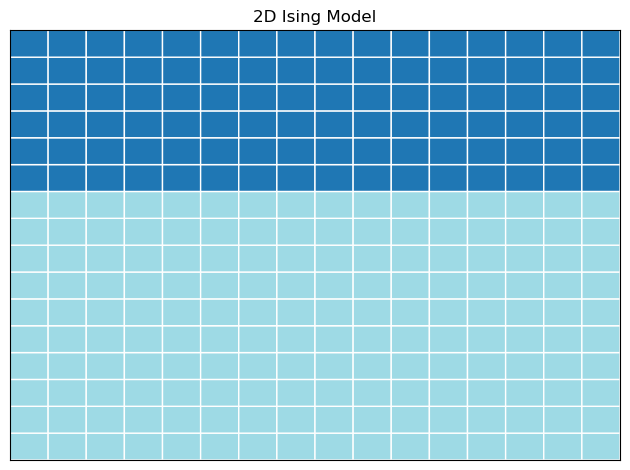

In [14]:
fig, ax= plt.subplots()
c = ax.pcolor(grid, edgecolors='white', linewidths=1, cmap='tab20')
ax.set_title('2D Ising Model')
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
fig.tight_layout()
plt.show()

# Magnetization of Temperature

Calculated with following approach: <br>
T = np.linspace(1.8,3.5,20) <br>
N = 64 <br>
steps = 40000000 <br>
equi = 20000000 <br>
J = 1 <br>
B = 0 <br>
<br>
m = m_of_Temp(T,N,steps,equi,J,B) <br>

In [40]:
data_64 = np.loadtxt("Data/Revising_64N_M_of_T.csv",skiprows = 1, delimiter=",")
data_32 = np.loadtxt("Data/Revising_32N_M_of_T.csv",skiprows = 1, delimiter=",")
data_16 = np.loadtxt("Data/Revision_16N_M_of_T.csv",skiprows = 1, delimiter=",")
calc_64 = np.loadtxt("N64calculated.csv", skiprows = 1, delimiter=",")
calc_32 = np.loadtxt("N32calculated.csv", skiprows = 1, delimiter=",")
calc_16 = np.loadtxt("N16calculated.csv", skiprows = 1, delimiter=",")

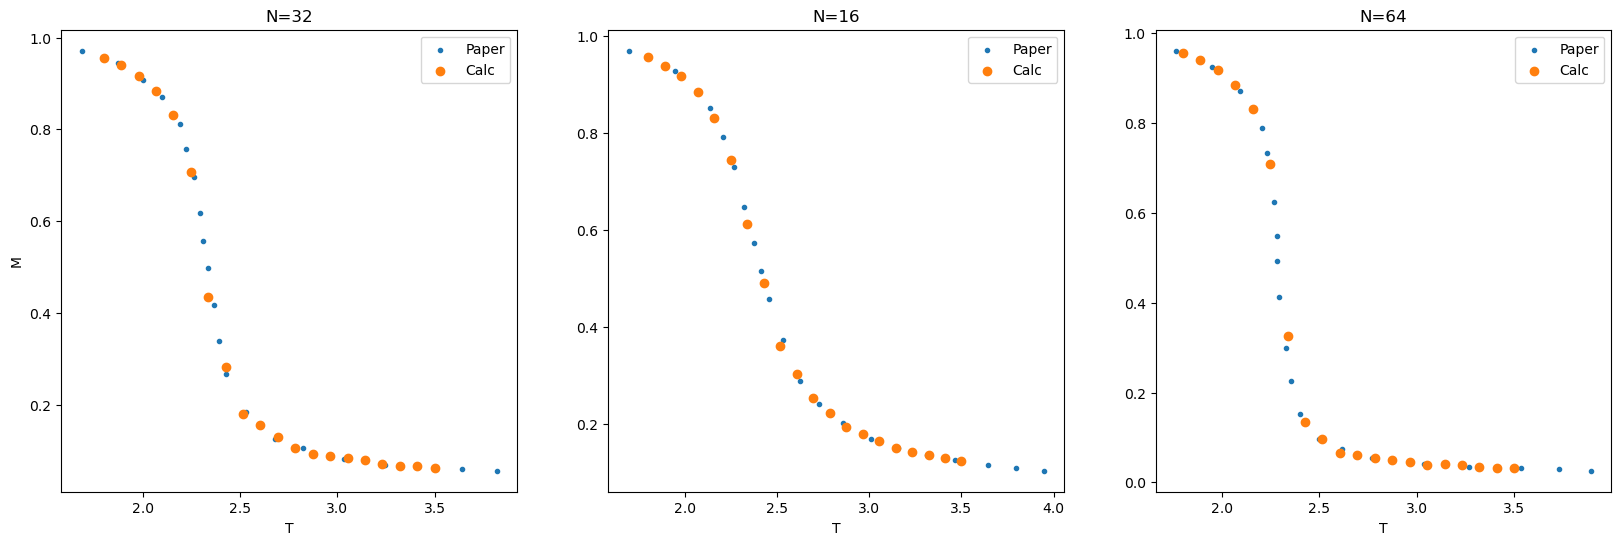

In [12]:
fig,ax = plt.subplots(1,3, figsize = (20,6))
ax[0].scatter(data_32[:,0],data_32[:,1], label = "Paper", marker = ".")
ax[1].scatter(data_16[:,0],data_16[:,1], label = "Paper", marker = ".")
ax[2].scatter(data_64[:,0],data_64[:,1], label = "Paper", marker = ".")
ax[0].scatter(calc_32[:,2],calc_32[:,1], label = "Calc")
ax[1].scatter(calc_16[:,2],calc_16[:,1], label = "Calc")
ax[2].scatter(calc_64[:,2],calc_64[:,1], label = "Calc")
ax[0].set_xlabel("T")
ax[1].set_xlabel("T")
ax[2].set_xlabel("T")
ax[0].set_title("N=32")
ax[1].set_title("N=16")
ax[2].set_title("N=64")
ax[0].set_ylabel("M")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

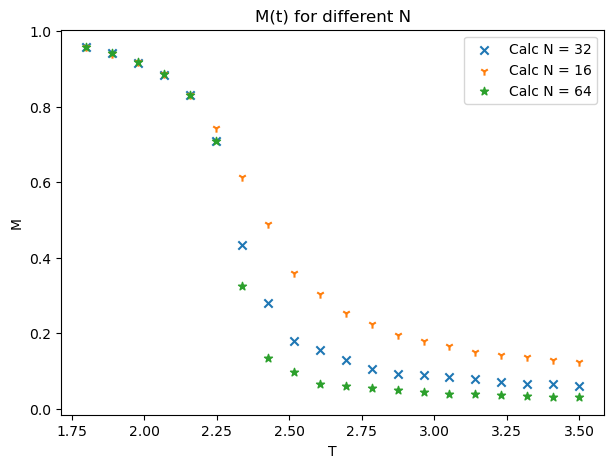

In [44]:
fig, ax = plt.subplots(1, figsize = (7,5))

ax.scatter(calc_32[:,2],calc_32[:,1], label = "Calc N = 32", marker = "x")
ax.scatter(calc_16[:,2],calc_16[:,1], label = "Calc N = 16", marker = "1")
ax.scatter(calc_64[:,2],calc_64[:,1], label = "Calc N = 64", marker = "*")
ax.legend()
ax.set_xlabel("T")
ax.set_ylabel("M")
ax.set_title("M(t) for different N")


plt.show()

## Magnetization of magnetic field B

/tmp/ipykernel_4911/931468510.py:5: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  M = m_of_t(steps, T, N, random, J, B[i])[0]
/tmp/ipykernel_4911/931468510.py:5: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  M = m_of_t(steps, T, N, random, J, B[i])[0]


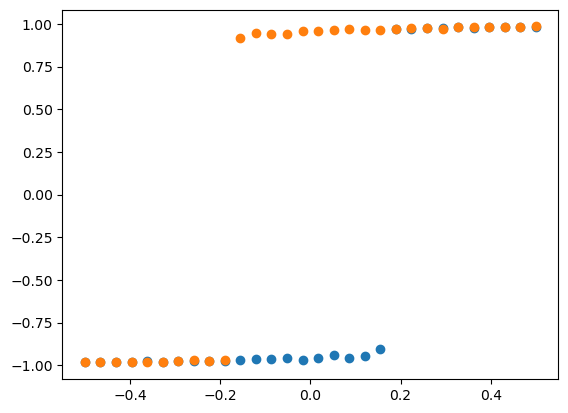

In [11]:
T = 1.8
N = 10
J = 1 
B = np.linspace(-0.5,0.5,30)
steps = 100000
equi = 50000

m_of_b = m_of_B(T,N,steps,equi,J,B,both = True, random = False)

plt.scatter(B,m_of_b[0])
plt.scatter(B,m_of_b[1])

dfx = pd.DataFrame(B,m_of_b)
dfx.to_csv('m_of_b.csv', mode='w', index=False, header=True)

# Hist and free energy

In [11]:
# Initialization variables
N = 10 # For small N
T = 2.5 # T not too small
random = True
J = 1
B = 0
steps = 20000000
equi = 10000000

# Running the simulation
m = m_of_t(steps, T, N, random, J, B, val = 1)[0]

/tmp/ipykernel_2383/101856324.py:5: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  grid = init(N, random)
/tmp/ipykernel_2383/101856324.py:9: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  M_diff = spin_flip(grid,T, J, B)


In [12]:
# creating the histogram
bins = np.linspace(-1, 1, 100)
bin_centers = (bins[:-1] + bins[1:]) / 2

density, bin_edges = np.histogram(m, bins, density = True)
free_energy = -np.log(density)

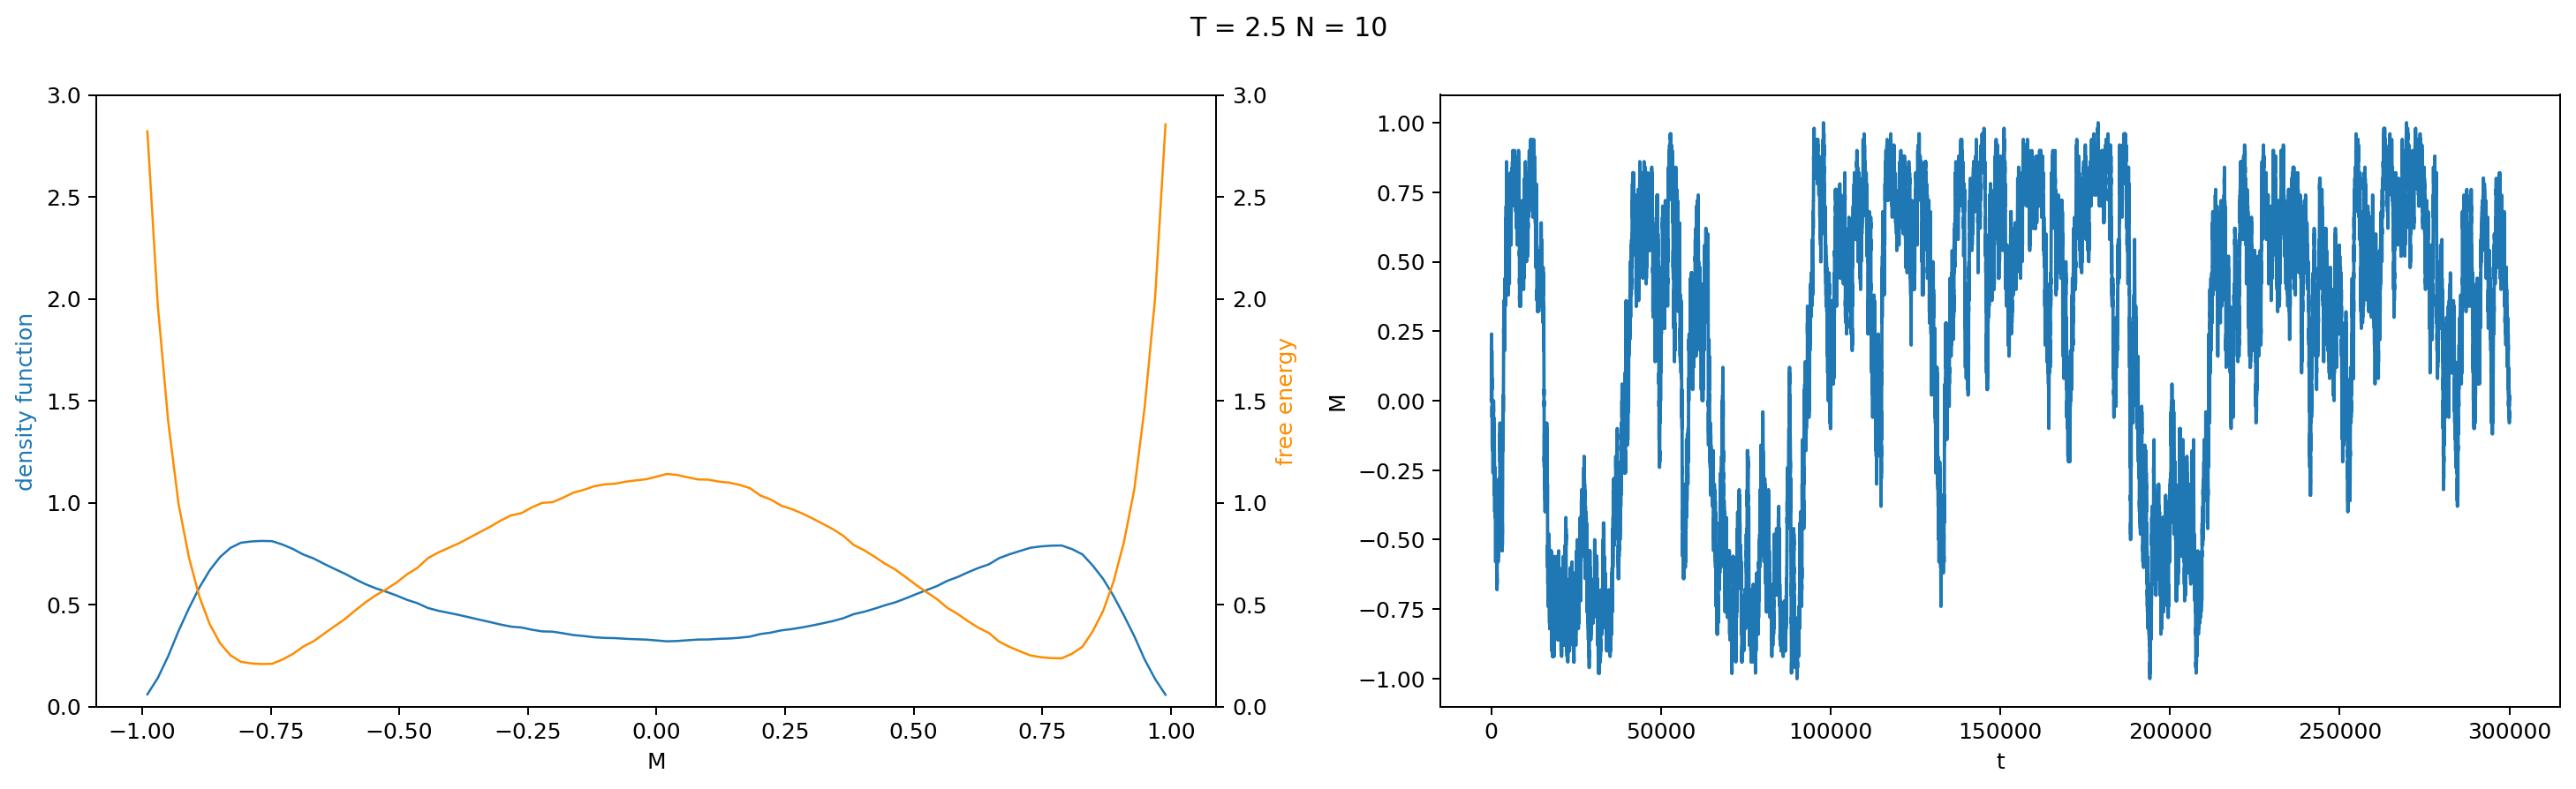

In [39]:
# Plotting
fig, ax = plt.subplots(1,2, figsize=(20,5), dpi=180)

ax[1].plot(np.arange(0,steps,1)[:300000],m[:300000])
ax[1].set_xlabel("t")
ax[1].set_ylabel("M")



ax[0].plot(bin_centers, density, lw=1, label='density', color = 'tab:blue')
#ax[0].plot(bin_centers, free_energy, lw=1, label='Free energy')
ax[0].set_xlabel("M")
ax[0].set_ylabel("density function").set_color('tab:blue')
ax[0].set_ylim([0,3])
ax2 = ax[0].twinx()
ax2.plot(bin_centers, free_energy, lw=1, label='Free energy', color = 'darkorange')
ax2.set_ylabel("free energy").set_color('darkorange')
ax2.set_ylim([0,3])
#ax[0].set_ylabel('Y1 data', color='g')
#ax2.set_ylabel('Y2 data', color='b')

fig.suptitle(f"T = {T} N = {N}")
plt.show()